In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df=pd.read_csv('/content/ananadvihar(8hr).csv')

In [ ]:
data.head()

,From Date,To Date,PM2.5,PM10,NO,NOx,NH3,SO2,CO,Ozone,...,Toluene,RH,WS,WD,SR,BP,AT,NO2,Datetime,Date
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-01,2024-01-01 00:00:00,2024-01-01 08:00:00,169.34,252.16,30.84,48.47,18.47,2.42,1.50,16.72,...,5.32,80.12,0.34,50.06,7.50,742.00,11.29,43.96,2024-01-01 00:00:00,NaN
2024-01-01,2024-01-01 08:00:00,2024-01-01 16:00:00,189.75,354.66,45.60,70.03,17.52,2.49,1.70,18.98,...,6.26,69.72,0.53,69.94,321.78,741.81,12.69,61.88,2024-01-01 08:00:00,NaN
2024-01-01,2024-01-01 16:00:00,2024-02-01 00:00:00,242.27,405.10,40.63,66.77,18.89,22.58,1.60,15.44,...,13.20,76.10,0.36,60.83,47.37,742.00,11.47,63.48,2024-01-01 16:00:00,NaN
2024-02-01,2024-02-01 00:00:00,2024-02-01 08:00:00,243.62,355.09,21.48,44.17,19.99,9.07,1.49,14.83,...,6.49,76.69,0.38,74.31,10.44,742.00,10.57,50.12,2024-02-01 00:00:00,NaN
2024-02-01,2024-02-01 08:00:00,2024-02-01 16:00:00,137.84,250.03,26.90,49.41,18.32,26.81,1.62,23.22,...,5.62,63.88,0.91,55.94,349.44,741.94,12.71,51.81,2024-02-01 08:00:00,NaN


In [ ]:
print(data.head())

print(data.isnull().sum())

                     From Date             To Date   PM2.5    PM10     NO  \
Date                                                                        
2024-01-01 2024-01-01 00:00:00 2024-01-01 08:00:00  169.34  252.16  30.84   
2024-01-01 2024-01-01 08:00:00 2024-01-01 16:00:00  189.75  354.66  45.60   
2024-01-01 2024-01-01 16:00:00 2024-02-01 00:00:00  242.27  405.10  40.63   
2024-02-01 2024-02-01 00:00:00 2024-02-01 08:00:00  243.62  355.09  21.48   
2024-02-01 2024-02-01 08:00:00 2024-02-01 16:00:00  137.84  250.03  26.90   

              NOx    NH3    SO2    CO  Ozone  ...  Toluene     RH    WS  \
Date                                          ...                         
2024-01-01  48.47  18.47   2.42  1.50  16.72  ...     5.32  80.12  0.34   
2024-01-01  70.03  17.52   2.49  1.70  18.98  ...     6.26  69.72  0.53   
2024-01-01  66.77  18.89  22.58  1.60  15.44  ...    13.20  76.10  0.36   
2024-02-01  44.17  19.99   9.07  1.49  14.83  ...     6.49  76.69  0.38   
2024-02-01

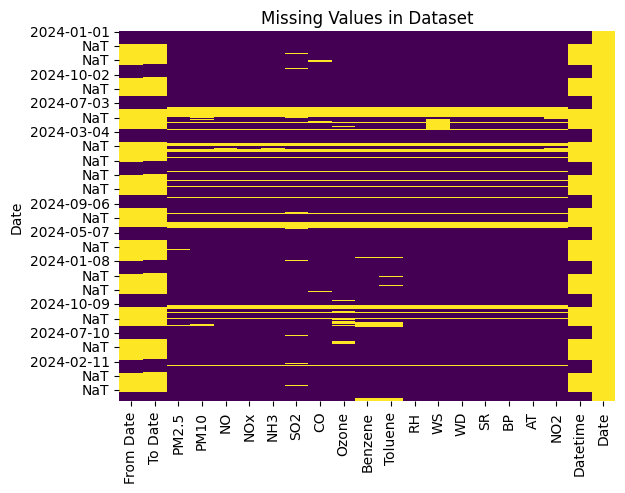

In [ ]:
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()

In [ ]:
def calculate_individual_aqi(concentration, breakpoints):

    for i in range(len(breakpoints) - 1):
        if concentration >= breakpoints[i][0] and concentration < breakpoints[i + 1][0]:
            C_low, C_high = breakpoints[i]
            I_low, I_high = breakpoints[i + 1]

            aqi = ((concentration - C_low) / (C_high - C_low)) * (I_high - I_low) + I_low
            return aqi

    return 500

def calculate_overall_aqi(row):

    pm25_breakpoints = [(0, 30), (30, 60), (60, 90), (90, 120), (120, 250), (250, 500)]
    pm10_breakpoints = [(0, 50), (50, 100), (100, 150), (150, 200), (200, 350), (350, 500)]
    so2_breakpoints = [(0, 40), (40, 80), (80, 380), (380, 800), (800, 1600), (1600, 3200)]
    no2_breakpoints = [(0, 40), (40, 80), (80, 180), (180, 280), (280, 400), (400, 600)]
    ozone_breakpoints = [(0, 50), (50, 100), (100, 140), (140, 180), (180, 240), (240, 300)]

    pm25_aqi = calculate_individual_aqi(row['PM2.5'], pm25_breakpoints)
    pm10_aqi = calculate_individual_aqi(row['PM10'], pm10_breakpoints)
    so2_aqi = calculate_individual_aqi(row['SO2'], so2_breakpoints)
    no2_aqi = calculate_individual_aqi(row['NO2'], no2_breakpoints)
    ozone_aqi = calculate_individual_aqi(row['Ozone'], ozone_breakpoints)


    overall_aqi = max(pm25_aqi, pm10_aqi, so2_aqi, no2_aqi, ozone_aqi)

    return overall_aqi


In [ ]:
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data[['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone']]))
data_imputed.columns = ['PM2.5', 'PM10', 'SO2', 'NO2', 'Ozone']


In [ ]:
data_imputed['Overall_AQI'] = data_imputed.apply(calculate_overall_aqi, axis=1)


In [ ]:
data_imputed['lag_1'] = data_imputed['Overall_AQI'].shift(1)
data_imputed['lag_2'] = data_imputed['Overall_AQI'].shift(2)
data_imputed['lag_3'] = data_imputed['Overall_AQI'].shift(3)

In [ ]:
data_imputed = data_imputed.dropna()

In [ ]:
X = data_imputed[['lag_1', 'lag_2', 'lag_3']]
y = data_imputed['Overall_AQI']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators=1000,
                             learning_rate=0.01,
                             max_depth=6,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             early_stopping_rounds=10,
                             objective='reg:squarederror')


In [ ]:
xgb_model.fit(X_train_scaled, y_train,
              eval_set=[(X_test_scaled, y_test)],
              verbose=True)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate model performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model - MSE: {mse_xgb:.2f}, R2: {r2_xgb:.2f}")


[0]	validation_0-rmse:123.67828
[1]	validation_0-rmse:122.89658
[2]	validation_0-rmse:122.09740
[3]	validation_0-rmse:121.33087
[4]	validation_0-rmse:120.56347
[5]	validation_0-rmse:119.82376
[6]	validation_0-rmse:119.10832
[7]	validation_0-rmse:118.45099
[8]	validation_0-rmse:117.72866
[9]	validation_0-rmse:117.10553
[10]	validation_0-rmse:116.40306
[11]	validation_0-rmse:115.73293
[12]	validation_0-rmse:115.12842
[13]	validation_0-rmse:114.47553
[14]	validation_0-rmse:113.83191
[15]	validation_0-rmse:113.16589
[16]	validation_0-rmse:112.57881
[17]	validation_0-rmse:111.95301
[18]	validation_0-rmse:111.33121
[19]	validation_0-rmse:110.74284
[20]	validation_0-rmse:110.13770
[21]	validation_0-rmse:109.52646
[22]	validation_0-rmse:109.01584
[23]	validation_0-rmse:108.39584
[24]	validation_0-rmse:107.83098
[25]	validation_0-rmse:107.29205
[26]	validation_0-rmse:106.74449
[27]	validation_0-rmse:106.23867
[28]	validation_0-rmse:105.70496
[29]	validation_0-rmse:105.21819
[30]	validation_0-rm

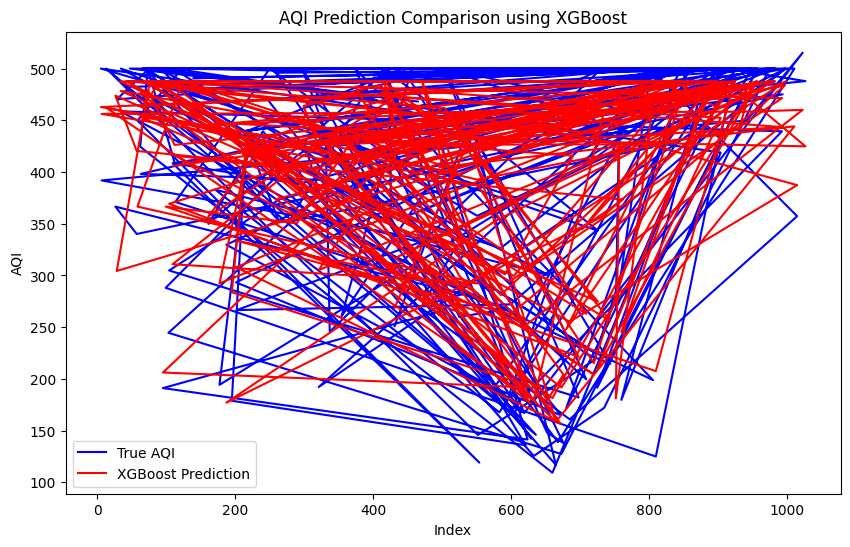

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True AQI", color='blue')
plt.plot(y_test.index, y_pred_xgb, label="XGBoost Prediction", color='red')
plt.legend()
plt.title('AQI Prediction Comparison using XGBoost')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 6, 8, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 0.1, 0.5, 1.0],
    'lambda': [0, 0.1, 0.5, 1.0]
}
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

best_xgb_model = grid_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test_scaled)

mse_best_xgb = mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

print(f"Best XGBoost Model - MSE: {mse_best_xgb:.2f}, R2: {r2_best_xgb:.2f}")


Fitting 3 folds for each of 11520 candidates, totalling 34560 fits
Best parameters found by GridSearchCV: {'alpha': 0, 'colsample_bytree': 0.8, 'lambda': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.6}
Best XGBoost Model - MSE: 5271.47, R2: 0.66


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True AQI", color='blue')
plt.plot(y_test.index, y_pred_best_xgb, label="Best XGBoost Prediction", color='green')
plt.legend()
plt.title('AQI Prediction Comparison using Best XGBoost Model')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.show()

Best XGBoost Model - MSE: 5459.04, R2: 0.65


In [ ]:
# Feature Importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_xgb_model, max_num_features=10, importance_type='weight')
plt.title('Feature Importance')
plt.show()


In [ ]:
# Random Forest Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)
print(f"Random Forest - MSE: {rf_mse:.2f}, R2: {rf_r2:.2f}")

In [ ]:
# LightGBM Model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train_scaled, y_train)
y_pred_lgb = lgb_model.predict(X_test_scaled)

lgb_mse = mean_squared_error(y_test, y_pred_lgb)
lgb_r2 = r2_score(y_test, y_pred_lgb)
print(f"LightGBM - MSE: {lgb_mse:.2f}, R2: {lgb_r2:.2f}")


In [ ]:
models = ['Random Forest', 'LightGBM', 'XGBoost']
mse_scores = [rf_mse, lgb_mse, xgb_mse]
r2_scores = [rf_r2, lgb_r2, xgb_r2]


plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title('Model Comparison - R2 Scores')
plt.ylabel('R2 Score')
plt.show()

# Visualize the comparison of MSE scores
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mse_scores, palette='magma')
plt.title('Model Comparison - MSE Scores')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label="True AQI", color='blue')
plt.plot(y_test.index, y_pred_xgb, label="XGBoost Prediction", color='green')
plt.legend()
plt.title('AQI Prediction Comparison using XGBoost')
plt.xlabel('Index')
plt.ylabel('AQI')
plt.show()

In [ ]:
#Ensemble Model using Voting Regressor
ensemble_model = VotingRegressor(estimators=[('rf', rf_model), ('lgb', lgb_model), ('xgb', xgb_model)])
ensemble_model.fit(X_train_scaled, y_train)
y_pred_ensemble = ensemble_model.predict(X_test_scaled)
ensemble_mse = mean_squared_error(y_test, y_pred_ensemble)
ensemble_r2 = r2_score(y_test, y_pred_ensemble)
print(f"Ensemble Model - MSE: {ensemble_mse:.2f}, R2: {ensemble_r2:.2f}")


In [ ]:
## next 7 day prediction
for i in range(7):

    latest_data_scaled = scaler.transform(latest_data[['PM2.5', 'PM10', 'NO', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene', 'Toluene', 'RH', 'WS', 'WD', 'SR', 'BP', 'AT', 'NO2', 'lag_1', 'lag_2']])


    next_day_prediction = ensemble_model.predict(latest_data_scaled)


    predictions.append(next_day_prediction[0])


    latest_data['lag_2'] = latest_data['lag_1']
    latest_data['lag_1'] = next_day_prediction[0]

print("Predicted AQI for the next 7 days:", predictions)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 8), predictions, marker='o', linestyle='-', color='green')
plt.title('Predicted AQI for the Next 7 Days')
plt.xlabel('Day')
plt.ylabel('Predicted AQI')
plt.xticks(range(1, 8))
plt.grid(True)
plt.show()